# 1D CNN model, utilizing Keras Call-back in training and optimization. 

Excercise project inspired by https://www.machinecurve.com/index.php/2020/02/18/how-to-use-k-fold-cross-validation-with-keras/#evaluating-the-performance-of-your-model,
https://machinelearningmastery.com/cnn-models-for-human-activity-recognition-time-series-classification/,
https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/#:~:text=Therefore%2C%20the%20optimal%20number%20of,values%20against%20number%20of%20epochs,
and https://towardsdatascience.com/addressing-the-difference-between-keras-validation-split-and-sklearn-s-train-test-split-a3fb803b733.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import tensorflow as tf

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

C:\Users\80136730\Anaconda3\envs\Deep\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\80136730\Anaconda3\envs\Deep\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\80136730\Anaconda3\envs\Deep\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\80136730\Anaconda3\envs\Deep\lib\site-packages\tensorflow\

In [3]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)

## Load data 

In [4]:
# Load data from https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
# and unzip all files into a new “HARDataset”directory in current working directory. 

In [5]:
# X_train_file = r'C:\Users\80136730\1dCNN\HARDataset\UCI HAR Dataset\train\Inertial Signals\body_acc_x_train.txt' 
# there are 8 more
# y_train_file = r'C:\Users\80136730\1dCNN\HARDataset\UCI HAR Dataset\train\y_train.txt'

# X_test_file = r'C:\Users\80136730\1dCNN\HARDataset\UCI HAR Dataset\test\Inertial Signals\body_acc_x_test.txt'  
# there are 8 more
# y_test_file = r'C:\Users\80136730\1dCNN\HARDataset\UCI HAR Dataset\test\y_test.txt'

In [6]:
def read_file(filepath):
    return pd.read_csv(filepath, header=None, delim_whitespace=True).values

def dstack_files(subset, filenames):
    file_list = []
    for name in filenames:
        file = read_file(subset + name)
        file_list.append(file)
    return np.dstack(file_list)

def load_group(dataset, group):
    subset = dataset + group + '/Inertial Signals/'
    filenames = ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt','body_acc_z_'+group+'.txt',
                 'body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt','body_gyro_z_'+group+'.txt',
                 'total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt','total_acc_z_'+group+'.txt']
    X = dstack_files(subset, filenames)
    y = read_file(dataset + group + '/y_' + group + '.txt')
    return X, y

def load_data(dataset=r'C:/Users/80136730/1dCNN/HARDataset/UCI HAR Dataset/'):
    X_train, y_train = load_group(dataset, 'train')
    X_test, y_test = load_group(dataset, 'test')
    return X_train, y_train, X_test, y_test 

In [7]:
Xtrain, ytrain, Xtest, ytest = load_data()

In [8]:
Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

((7352, 128, 9), (7352, 1), (2947, 128, 9), (2947, 1))

In [10]:
fullX = np.concatenate((Xtrain, Xtest))
fully = np.concatenate((ytrain, ytest))

In [16]:
fullX.shape, fully.shape

((10299, 128, 9), (10299, 1))

In [17]:
# one hot encode y
fully_hot = to_categorical(fully-1, num_classes=6)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(fullX, fully_hot, test_size=0.18, random_state=88)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=88)

In [19]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape 

((6756, 128, 9),
 (1689, 128, 9),
 (1854, 128, 9),
 (6756, 6),
 (1689, 6),
 (1854, 6))

In [28]:
# what are the input and output data shapes? 
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [29]:
# build CNN model
cnn1d_model = Sequential()
cnn1d_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
cnn1d_model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn1d_model.add(Dropout(0.5))
cnn1d_model.add(MaxPooling1D(pool_size=2))
cnn1d_model.add(Flatten())
cnn1d_model.add(Dense(100, activation='relu'))
cnn1d_model.add(Dense(n_outputs, activation='softmax'))
cnn1d_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
from keras import callbacks

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 3, 
                                        restore_best_weights = True, verbose = 1)

In [30]:
history = cnn1d_model.fit(X_train, y_train, batch_size = 500, epochs = 25, 
                    validation_data =(X_val, y_val), 
                    callbacks =[earlystopping])


Train on 6756 samples, validate on 1689 samples
Epoch 1/25
6756/6756 [==============================] - 3s 391us/step - loss: 0.9899 - accuracy: 0.6177 - val_loss: 0.6053 - val_accuracy: 0.7762
Epoch 2/25
6756/6756 [==============================] - 2s 360us/step - loss: 0.4965 - accuracy: 0.7980 - val_loss: 0.4594 - val_accuracy: 0.8360
Epoch 3/25
6756/6756 [==============================] - 3s 407us/step - loss: 0.3592 - accuracy: 0.8655 - val_loss: 0.3689 - val_accuracy: 0.8774
Epoch 4/25
6756/6756 [==============================] - 3s 512us/step - loss: 0.2622 - accuracy: 0.9044 - val_loss: 0.2809 - val_accuracy: 0.9047
Epoch 5/25
6756/6756 [==============================] - 3s 481us/step - loss: 0.1980 - accuracy: 0.9298 - val_loss: 0.2359 - val_accuracy: 0.9307
Epoch 6/25
6756/6756 [==============================] - 3s 403us/step - loss: 0.1693 - accuracy: 0.9368 - val_loss: 0.2136 - val_accuracy: 0.9295
Epoch 7/25
6756/6756 [==============================] - 3s 425us/step - los

In [46]:
def plot_histories(history, metrics = history.history.keys()):
    
    fig, axes = plt.subplots(nrows = (len(metrics) - 1) // 2 + 1, ncols = 2, figsize = (12,8))
    
    for i,metric in enumerate(metrics):        
        axes[(i+2)//2 - 1, 1 - (i+1)%2].plot(history.history[metric])
        axes[(i+2)//2 - 1, 1 - (i+1)%2].set_xticks(np.arange(len(history.history[metric])))
        axes[(i+2)//2 - 1, 1 - (i+1)%2].set_xticklabels(1+np.arange(len(history.history[metric])))
        axes[(i+2)//2 - 1, 1 - (i+1)%2].set_title(metric)

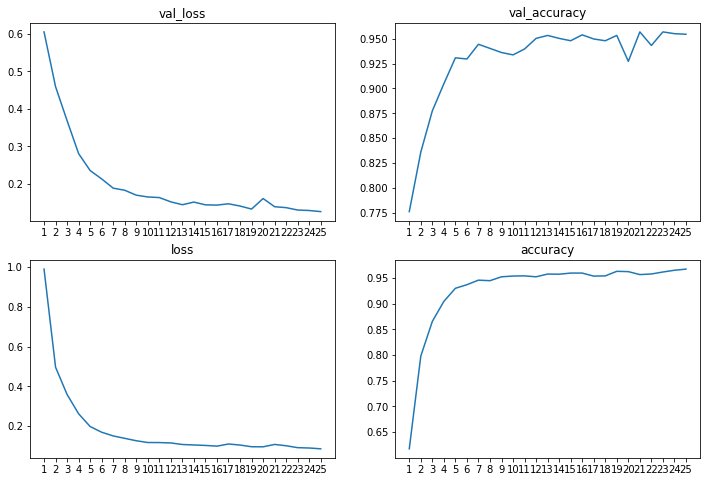

In [47]:
plot_histories(history)

In [ ]:
# number of epochs should not exceed 18

In [ ]:
"""
Callbacks

callback_progbar_logger()

Callback that prints metrics to stdout.

callback_model_checkpoint()

Save the model after every epoch.

callback_early_stopping()

Stop training when a monitored quantity has stopped improving.

callback_remote_monitor()

Callback used to stream events to a server.

callback_learning_rate_scheduler()

Learning rate scheduler.

callback_tensorboard()

TensorBoard basic visualizations

callback_reduce_lr_on_plateau()

Reduce learning rate when a metric has stopped improving.

callback_terminate_on_naan()

Callback that terminates training when a NaN loss is encountered.

callback_csv_logger()

Callback that streams epoch results to a csv file

callback_lambda()

Create a custom callback

KerasCallback

(Deprecated) Base R6 class for Keras callbacks
"""

In [ ]:
# Approaches for further model optimization: 
    # normalize data
    # varing model construction (layers)
    # kernal (window) size
    # multi-headed CNN with different hyperparameters